
# Lecture 3 — Optimization (Unconstrained & Constrained)


## Learning outcomes


By the end of this lecture you will be able to:

- Understand the connection between root finding and the minimization/maximization problem. 

- Derive Newton’s method for **unconstrained** optimization from a Taylor Series Expansion (TSE) and relate it to the root-finding Newton method (replace $F$ by $\nabla f$, and $J$ by $H$).

- Formulate optimization problems with the appropriate mathematical notation.

- Understand the difference between constrained and unconstrained optimization.

- Implement a basic optimization algorithm based on **Newton's method** using gradients and Hessians.

- Set up **curve fitting / parameter estimation** as minimization of a **sum of squared estimate of errors (SSE)**.

- Solve **constrained** problems with `scipy.optimize.minimize` using gradients when available.

- Recognize when **derivative-free** optimization (e.g., Nelder–Mead simplex) can be potentially useful and its trade-offs.




## 1) Motivation (ChemE examples)

- **Parameter estimation:** infer kinetic or transport parameters from data by minimizing sum of squared estimate of errors (SSE).



- **Design & operation:** minimize energy/utility cost subject to mass/energy balances and bounds.


- **Control & planning:** optimize set points or planning variables with constraints



Optimization allows us to **choose decision variables optimal values (also known as degrees of freedom)** to minimize a scalar objective (with or without constraints).


## 2) Unconstrained Optimization

### Problem Formulation
We want to solve the unconstrained problem

$$
\min_x f(x)
$$

In which $x$ might be a single variable (scalar) or a vector (multivariate). The logic for looking for an optimum point in both cases remains the same. We separate both, so we can properly deal with vectors in the multivariate cases in a mathematical tractable and formal way.

### Single-Variable Case (1D)

If we are at a minimum or maximum point of the function (extrema), we have the condition that the derivative is zero:

**First-order necessary condition (FONC)**  
At a candidate optimum $x^\star$,

$$
f'(x^\star) = 0
$$

This ensures the tangent is flat (horizontal slope).



**Second-order conditions (SOC).**  
Examine the second derivative at $x^\star$:
- If $f''(x^\star) > 0$, then $x^\star$ is a **strict local minimum** (the curve is convex-up).
- If $f''(x^\star) < 0$, then $x^\star$ is a **local maximum**.
- If $f''(x^\star) = 0$, the test is inconclusive; higher-order terms or other analysis is needed.

So, in plain english: **first derivative = flatness, second derivative = curvature.**

Why is that true? optimization is closely tied to **root-finding**:  

- In one variable, finding a minimum of $f(x)$ requires solving  

  $$
  f'(x^\star) = 0,
  $$

  which is just finding the **root** of the derivative.  

- In several variables, we require  

  $$
  \nabla f(x^\star) = 0,
  $$

  i.e., solving a **system of equations** given by the gradient.  

This is why Newton’s method for optimization is essentially Newton’s method applied to the gradient.  

Let's take a look at this with an actual function.

$$y(x) = (x - 1)^2 + 0.5$$

$$\frac{dy}{dx}=y'(x) = 2(x-1)$$

if 

$$ y'(x)=0 $$

then, 

$$2(x-1)=0 \leftarrow\rightarrow x=1$$

Taking another derivative, we have 


$$\frac{d^2y}{dx^2}=y''(x) = 2 \geq 0 $$


Based on the first and second order conditions, this is a minimum. Let's plot and see.



In [1]:
import numpy as np

In [2]:
def f(x): 
    return (x - 1.0)**2 + 0.5  

x = np.linspace(-2, 4, 400)
x_star = 1.0  
y = f(x)

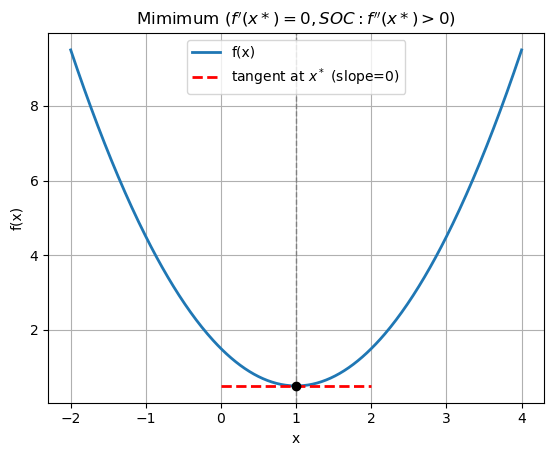

In [3]:
import matplotlib.pyplot as plt


plt.plot(x, y, lw=2, label='f(x)')
plt.axvline(x_star, color='gray', ls='--', lw=1)
plt.plot([x_star-1, x_star+1], [f(x_star), f(x_star)], 'r--', lw=2, label='tangent at $x^*$ (slope=0)')
plt.scatter([x_star], [f(x_star)], color='k', zorder=5)
plt.title("Mimimum $(f'(x*)=0, SOC: f''(x*)>0)$")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.legend(); plt.grid(True); plt.show()

Another example, 

$$y(x) = -(x+1)^2 + 3$$

$$y'(x) = 0 = 2(x+1)\leftarrow\rightarrow x = -1$$

$$ y''(x) = -2 $$

Which is a maximum. Let's check again.

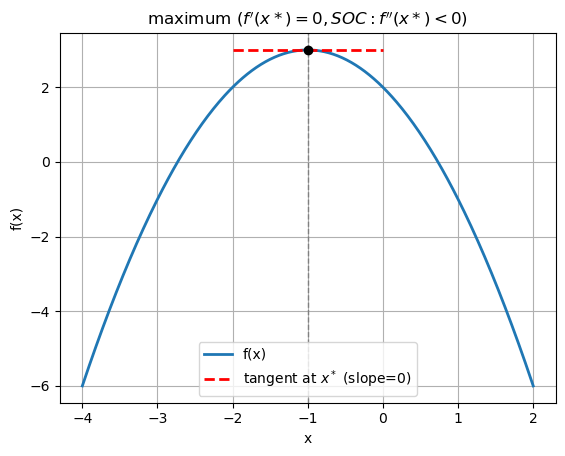

In [4]:
def f2(x): 
    return -(x + 1.0)**2 + 3.0 

x = np.linspace(-4, 2, 400)
x_star = -1.0
y = f2(x)

plt.plot(x, y, lw=2, label='f(x)')
plt.axvline(x_star, color='gray', ls='--', lw=1)
plt.plot([x_star-1, x_star+1], [f2(x_star), f2(x_star)], 'r--', lw=2, label='tangent at $x^*$ (slope=0)')
plt.scatter([x_star], [f2(x_star)], color='k', zorder=5)
plt.title("maximum $(f'(x*)=0, SOC: f''(x*)<0)$")
plt.xlabel("x"); plt.ylabel("f(x)")
plt.legend(); plt.grid(True); plt.show()

### Why This Carries Over to Higher Dimensions

In higher dimensions, $f:\mathbb{R}^n \to \mathbb{R}$, the same geometric intuition applies:

- The **gradient $\nabla f(x)$** generalizes the derivative:  
  - In 1D, $f'(x^\star)=0$ means slope $=0$.  
  - In nD, $\nabla f(x^\star)=0$ means **no slope in any direction**.  

- The **Hessian $H(x)$** generalizes the second derivative:  
  - In 1D, $f''(x^\star)>0$ means “curved upward.”  
  - In nD, $H(x^\star)$ positive definite means the function curves upward in **every direction**, hence a strict local minimum.  

Thus, the same logic extends naturally: flatness (first order condition) + curvature (second order condition).


### Newton’s Method for Optimization via Taylor Series Expansion (TSE)

#### From Root-Finding to Optimization
In root-finding, we solved  

$$f(x) = 0$$

For optimization, the **first-order condition** says that at a minimizer $x^\star$ we must have

$$\nabla f(x^\star) = 0$$

So optimization reduces to **finding a root of the gradient!**

#### Taylor Expansion of the Gradient
Let $g(x) = \nabla f(x)$ (the gradient). Expand $g$ around the current iterate $x_k$ using a first-order Taylor series:

$$
g(x) \approx g(x_k) + H(x_k)\,(x - x_k),
$$

where $H(x_k) = \nabla^2 f(x_k)$ is the Hessian, which is defined as:

$$
H(x) = \nabla^2 f(x) =
\begin{bmatrix}
\frac{\partial^2 f(x)}{\partial x_1^2} & \frac{\partial^2 f(x)}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f(x)}{\partial x_1 \partial x_n} \\[1.2ex]
\frac{\partial^2 f(x)}{\partial x_2 \partial x_1} & \frac{\partial^2 f(x)}{\partial x_2^2} & \cdots & \frac{\partial^2 f(x)}{\partial x_2 \partial x_n} \\[1.2ex]
\vdots & \vdots & \ddots & \vdots \\[1.2ex]
\frac{\partial^2 f(x)}{\partial x_n \partial x_1} & \frac{\partial^2 f(x)}{\partial x_n \partial x_2} & \cdots & \frac{\partial^2 f(x)}{\partial x_n^2}
\end{bmatrix}
$$

#### Impose Root Condition on Gradient Function!
At the next iterate $x_{k+1}$, we want $g(x_{k+1}) = 0$. Substitute into the expansion:

$$
0 \approx g(x_k) + H(x_k)\,(x_{k+1} - x_k)
$$

#### Solve for the Newton Step
Rearrange to obtain the Newton step for optimization:

$$
H(x_k)\,(x_{k+1} - x_k) = -\,g(x_k),
$$

so

$$
x_{k+1} = x_k - H(x_k)^{-1}\,g(x_k).
$$

This mirrors the root-finding Newton step, with the identifications $F \equiv g$ and $J \equiv H$.

#### Single-Variable Special Case
If $f:\mathbb{R}\to\mathbb{R}$, then $g(x) = f'(x)$ and $H(x) = f''(x)$, giving the classic 1D Newton update for optimization:

$$
x_{k+1} = x_k - \frac{f'(x_k)}{f''(x_k)}.
$$


How would we implement this as an algorithm?

### Pseudocode: Newton's Method for Optimization

**Inputs:**  
- Objective function $f(x)$  
- Gradient $\nabla f(x)$  
- Hessian $\nabla^2 f(x)$  
- Initial guess $x_0$  
- Tolerance $\varepsilon$  
- Maximum iterations $N_{\text{max}}$

**Algorithm:**
1. Set $k = 0$.
2. Initialize $x = x_0$.
3. **While** $k < N_{\text{max}}$:  
   a. Compute gradient $g = \nabla f(x)$.  
   b. If $\| g \| < \varepsilon$, **stop** (converged).  
   c. Compute Hessian $H = \nabla^2 f(x)$.  
   d. Solve the linear system $H d = -g$ for the step $d$.  
   e. Update $x \leftarrow x + d$.  
   f. Increment $k \leftarrow k+1$.
4. **Return** final point $x$.

**Outputs:**  
- Approximate minimizer $x^\ast$  

**Optional (diagnosis)**
- Gradient norm $\| g \|$  
- Number of iterations

In actual code, this is how it looks like:

In [5]:
import numpy as np

def newton_min(f, grad, hess, x0, tol=1e-8, max_iter = 50):


    """
    Newton's method for minimization.


    Inputs
    ------

    f: function
        The function we want to minimize.

    grad
        Gradient of the function.
    
    hess
        Hessian of the function.
    
    x0
        Initial estimate.
    
    tol
        Tolerance.
    max_iter
        Max. number of iterations

    Returns
    -------

    x
        approximate minimizer of the function f.
    
    iter
        # of iterations.
    sol
        Value of f(x) at the solution
    
    
    
    """

    x = x0

    for k in range(max_iter):

        H = hess(x)

        eigenvals = np.linalg.eigvals(H)

        if np.any(eigenvals <= 0 ):
            raise ValueError(f"Hessian not positive definite at iteration {k}")
        

        d = np.linalg.inv(H) @ grad(x)
        x_new = x - d

        if np.linalg.norm(grad(x_new), ord = 2) < tol: # Function norm small enough. Stop.
            
            return x_new, k+1, np.abs(f(x_new)), np.linalg.norm(grad(x_new), ord = 2)
        
        if np.linalg.norm((x_new -  x), ord = 2) < 1e-14:

            return x_new, k+1, np.abs(f(x_new)), np.linalg.norm(grad(x_new), ord = 2)
        
        x = x_new

    fx = f(x)
    x = x_new

    raise ValueError(f"Newton's method did not converge after {k+1} iterations;", f"x={x:.6f}, f(x)={fx:.6f}")








We are checking the hessian curvature here and exiting if it's not positive definite. But this is not exactly how this is handled in large-scale optimization algorithms. We just don't give up if during an iteration, the curvature is not going towards decrease. 


It is beyond of the scope of today's class, but what actually happens is the solvers are built such that hessian approximations are generated in a way that we will always have a positive curvature (hopefully). One of the techniques employed is [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition).


### Unconstrained example (simple convex "bowl")

Let's look at this example, visually.
$$
f(x,y)=(x-1)^2 + 10\,(y-2)^2,\quad
\nabla f(x,y)=\begin{bmatrix}2(x-1)\\ 20(y-2)\end{bmatrix},\quad
H=\begin{bmatrix}2&0\\0&20\end{bmatrix}.
$$


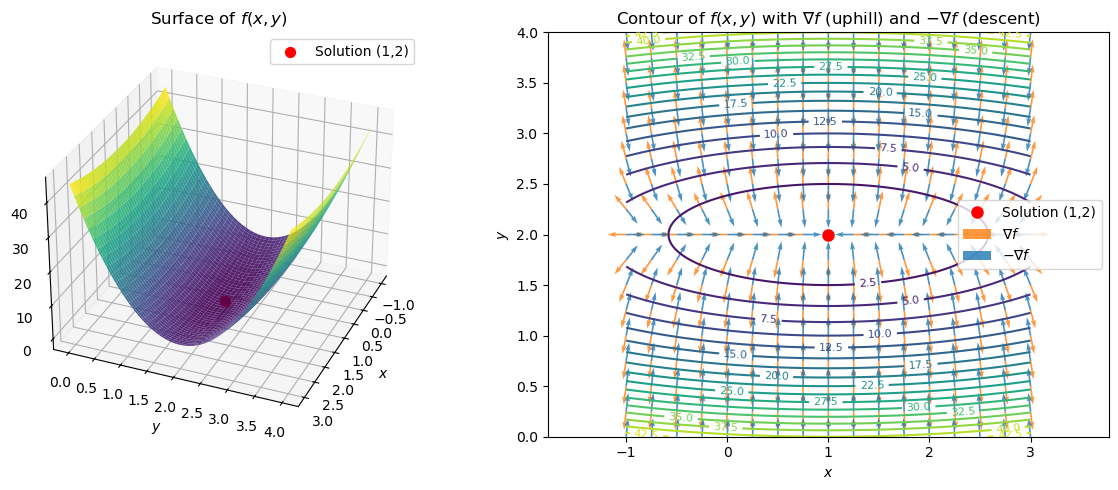

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 


def f_xy(v):
    x, y = v
    return (x-1)**2 + 10*(y-2)**2

# Gradient: g(x,y) = [2(x-1), 20(y-2)]
def grad_xy(x, y):
    return np.array([2*(x - 1.0), 20*(y - 2.0)])

# Grid for plotting
x = np.linspace(-1, 3, 200)
y = np.linspace(0, 4, 200)
X, Y = np.meshgrid(x, y)
Z = np.array([[f_xy([xi, yi]) for xi, yi in zip(row_x, row_y)]
              for row_x, row_y in zip(X, Y)])

# 3D Surface Plot 
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf = ax1.plot_surface(X, Y, Z, cmap="viridis", alpha=0.9, edgecolor="none")
ax1.scatter(1, 2, f_xy([1, 2]), color="r", s=50, label="Solution (1,2)")
ax1.view_init(elev=30, azim=22.5) 
ax1.set_title("Surface of $f(x,y)$")
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")
ax1.set_zlabel("$f(x,y)$")
ax1.legend()

# Contour Plot with Gradient Field 
ax2 = fig.add_subplot(1, 2, 2)
contours = ax2.contour(X, Y, Z, levels=20, cmap="viridis")
ax2.clabel(contours, inline=True, fontsize=8)
ax2.plot(1, 2, 'ro', markersize=8, label="Solution (1,2)")

# Sparse grid for vectors to avoid clutter
xs = np.linspace(-1, 3, 17)
ys = np.linspace(0, 4, 17)
XS, YS = np.meshgrid(xs, ys)

# Compute gradient and (negative) gradient for arrows
G = np.array([grad_xy(xi, yi) for xi, yi in zip(XS.ravel(), YS.ravel())])
Ux = G[:, 0].reshape(XS.shape)     # ∇f x-component (uphill)
Uy = G[:, 1].reshape(YS.shape)     # ∇f y-component
Vx = -Ux                           # -∇f (steepest descent)
Vy = -Uy

# Normalize for nicer arrows (optional)
norm = np.sqrt(Ux**2 + Uy**2) + 1e-12
Ux_n = Ux / norm
Uy_n = Uy / norm
Vx_n = Vx / norm
Vy_n = Vy / norm

# Plot both gradient and negative gradient (different styles)
ax2.quiver(XS, YS, Ux_n, Uy_n, color='tab:orange', alpha=0.8, scale=30, width=0.003, label=r"$\nabla f$")
ax2.quiver(XS, YS, Vx_n, Vy_n, color='tab:blue', alpha=0.8, scale=30, width=0.003, label=r"$-\nabla f$")

ax2.set_title(r"Contour of $f(x,y)$ with $\nabla f$ (uphill) and $-\nabla f$ (descent)")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")
ax2.legend()
ax2.axis("equal")

plt.tight_layout()
plt.show()

In the figure above we see some important geometrical insight: The negative gradient gives the fastest direction to the minimizer $x^*$!

If we solve this, we should get $x^*=[1,2]$

In [7]:
def f_xy(v):
    x, y = v
    return (x-1)**2 + 10*(y-2)**2

def g_xy(v):
    x, y = v
    return np.array([2*(x-1), 20*(y-2)])

def H_xy(v):
    return np.array([[2.0, 0.0],
                     [0.0, 20.0]])



In [8]:
x_star, iters, info, norm_grad = newton_min(f_xy, g_xy, H_xy, x0=[-1.0, 4.0])
print("x* =", x_star, "| iters:", iters, "|f(x):", info, "| |gradient|:", norm_grad)

x* = [1. 2.] | iters: 1 |f(x): 0.0 | |gradient|: 0.0


In [9]:
import scipy as sp

?sp.optimize.minimize

Signature:
sp.optimize.minimize(
    fun,
    x0,
    args=(),
    method=None,
    jac=None,
    hess=None,
    hessp=None,
    bounds=None,
    constraints=(),
    tol=None,
    callback=None,
    options=None,
)
Docstring:
Minimization of scalar function of one or more variables.

Parameters
----------
fun : callable
    The objective function to be minimized::

        fun(x, *args) -> float

    where ``x`` is a 1-D array with shape (n,) and ``args``
    is a tuple of the fixed parameters needed to completely
    specify the function.

    Suppose the callable has signature ``f0(x, *my_args, **my_kwargs)``, where
    ``my_args`` and ``my_kwargs`` are required positional and keyword arguments.
    Rather than passing ``f0`` as the callable, wrap it to accept
    only ``x``; e.g., pass ``fun=lambda x: f0(x, *my_args, **my_kwargs)`` as the
    callable, where ``my_args`` (tuple) and ``my_kwargs`` (dict) have been
    gathered before invoking this function.
x0 : ndarray, shape (n,)
  

In [10]:
import scipy as sp 
x0=[-1.0, 4.0]

solution = sp.optimize.minimize(fun=f_xy, x0=x0, jac=g_xy, hess=H_xy, method='Newton-CG')


print(solution)

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 4.930380657631324e-32
       x: [ 1.000e+00  2.000e+00]
     nit: 3
     jac: [ 4.441e-16  0.000e+00]
    nfev: 3
    njev: 3
    nhev: 3


Not providing the gradient gives:

In [11]:
solution = sp.optimize.minimize(fun=f_xy, x0=x0)
print(solution)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.2851873995774238e-12
        x: [ 1.000e+00  2.000e+00]
      nit: 7
      jac: [ 1.724e-06  8.036e-06]
 hess_inv: [[ 5.034e-01  1.591e-03]
            [ 1.591e-03  5.074e-02]]
     nfev: 24
     njev: 8


It takes more iterations to reach to the same answer!


## 3) Curve fitting / parameter estimation as optimization -- Sum of Squared Estimate of Errors (SSE)

Given data $\{x_i, y_i\}$ and a model $\hat y(x;\theta)$, estimate parameters $\theta$ by solving the following optimization problem:


$$
\min_\theta\ \text{SSE}(\theta)=\sum_{i=1}^m \big(y_i-\hat y(x_i;\theta)\big)^2
$$

In this case, our degrees of freedom (variables the optimizer manipulates to minimize the error between experimental data and the model predictions) are the parameters we want to estimate!

Let's look at a simple example.

**First-order batch reactor profile:** $\ \hat C(t;k)=C_0 e^{-k t}$

and we want to determine $k$. The SSE is defined, as well as the Gradient and the Hessian (since the only variable here is $k$, these are merely first and second order single-variable derivatives.)

$$
\text{SSE}(k)=\sum_i\big(C_i - C_0 e^{-k t_i}\big)^2,\qquad \\

\frac{d\,\text{SSE}}{dk}
=2\sum_i \big(C_i-\hat C_i\big)\, t_i\,\hat C_i,\ \
$$

$$
\frac{d^2\,\text{SSE}}{dk^2}
=2\sum_i \left[ (t_i \hat C_i)^2 - (C_i-\hat C_i)\,t_i^2\,\hat C_i \right],
\qquad \hat C_i = C_0 e^{-k t_i}
$$



In our example, I intentionally added noise to the synthetic data, as a way to mimic real data that is noisy. Hence, the value of $k$ we are going to obtain is not exactly the same when compared against the real value. This is very common in chemical engineering: We estimate parameters for our models using experimental data all the time, and they are, most likely, not $100\%$ accurate, as experiments (and experimental data) contain noise/randomnes. 

Anyway, let's solve this by minimizing the SSE with ``scipy.optimize.minimize``


Using Scipy:
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.005832625399270045
       x: [ 5.598e-01]
     nit: 6
     jac: [-2.527e-07]
    nfev: 7
    njev: 7
    nhev: 7
    hess: [[ 2.673e+00]]
Estimated k = 0.5598385750717667
-----------------------------------------------------------------------------------------------
Using Our Newton's method:
k_hat = [0.55983867] | iters: 7 |f(x): 0.0058326253992581015 | |gradient|: 8.935213680061338e-14
Estimated k = 0.5598385750717667
-----------------------------------------------------------------------------------------------


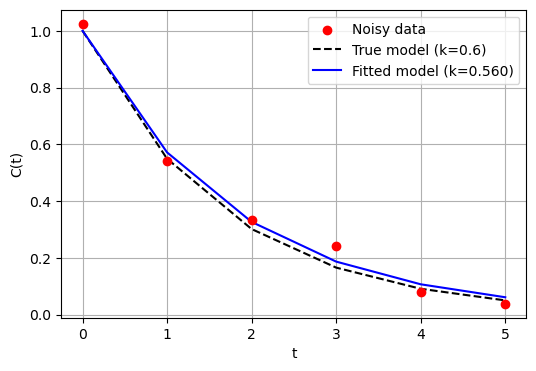

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# synthetic data
t = np.array([0., 1., 2., 3., 4., 5.])
C0 = 1.0
k_true = 0.6
C_true = C0 * np.exp(-k_true * t)

# adding some noise
np.random.seed(42) 
noise_level = 0.05 
C = C_true + noise_level * np.random.randn(t.size)

# objective, gradient, hessian
def SSE(k):
    Chat = C0 * np.exp(-k * t)
    return np.sum((C - Chat)**2)

def dSSE_dk(k):
    Chat = C0 * np.exp(-k * t)
    grad = 2.0 * np.sum((C - Chat) * t * Chat)
    return np.array([grad])

def d2SSE_dk2(k):
    Chat = C0 * np.exp(-k * t)
    term1 = (t * Chat)**2
    term2 = (C - Chat) * (t**2 * Chat)
    hess = 2.0 * np.sum(term1 - term2)
    return np.array([[hess]])


# Solution using scipy
sol = minimize(SSE, x0=0.2, jac=dSSE_dk, hess=d2SSE_dk2, method='trust-exact')

k_hat = sol.x[0]

print('Using Scipy:')
print(sol)
print("Estimated k =", k_hat)
print('-----------------------------------------------------------------------------------------------')
# Solution using our Newton's method.


k_hat_newton, iters, info, norm_grad = newton_min(SSE, dSSE_dk, d2SSE_dk2, x0=0.2)

print("Using Our Newton's method:")
print("k_hat =", k_hat_newton, "| iters:", iters, "|f(x):", info, "| |gradient|:", norm_grad)

print("Estimated k =", k_hat)
print('-----------------------------------------------------------------------------------------------')
# fitted curve
C_fit = C0 * np.exp(-k_hat * t)

# plot
plt.figure(figsize=(6,4))
plt.scatter(t, C, color="red", label="Noisy data", zorder=3)
plt.plot(t, C_true, "k--", label="True model (k=0.6)")
plt.plot(t, C_fit, "b-", label=f"Fitted model (k={k_hat:.3f})")
plt.xlabel("t")
plt.ylabel("C(t)")
plt.legend()
plt.grid(True)
plt.show()

You can see that we got pretty close to the real value used in the model (0.6). But there is some error.


## 4) Constrained optimization with `scipy.optimize.minimize`


It is common that we need to find an optimal solution *subject to* some mathematical relationship that represents what we call a *constraint*. These constraints in chemical engineering sometimes appear due to physical limitations of equipment, economic profitability or even safety regulations. 

For example, the operating temperature of a chemical reactor should not surpass a certain safe value, or the physical dimensions of a distillation column are limited by the economics, or the purity of a product in a chemical plant has to be above a certain value. These are all examples of constraints. Yet, we still need to try to find optimal solutions of such examples that are described mathematically. Let's take a look at the **problem form**:



$$
\min_{x\in\mathbb{R}^n} f(x)\quad \\
\text{s.t.}\\ \;\; c(x)=0 \quad \\ g(x)\le 0\  \\ x_{l} < x < x_{u}
$$


You may see this in more details in your next courses, but the gist of the formulation above is that the constraints $c(x)$ and $g(x)$ and the objective function $f(x)$ are rewritten such that we can use our knowledge about unconstrained optimization to solve the constrained optimization problem. We build a function called the Lagrangian, which assembles the constraints and the objective function together:

$$
\mathcal{L}\left(x, \lambda_1, \lambda_2\right)=f(x) + \lambda_1 c(x) + \lambda_2 g(x)
$$

And we solve this problem instead. This is what `scipy.optimize.minimize` is doing under the hood.

## Example -- Minimizing Surface Area of a Plug-flow Reactor

Let's take a look at an example. Say you are given the task of calculating the minimum surface area necessary to manufacture a plug-flow reactor (PFR). Simultaneously, you are given the information that there is a minimum volume that the reactor should have, so the reaction is profitable (i.e., $2m^3$). Lastly, to ensure that this PFR actually follows the plug-flow assumption, you need to have the length-to-diameter ration of *at least* 30.

This translates mathematically as the following problem:

$$
\begin{aligned}
\min_{D,L}\quad & A(D,L) = \pi D L + \tfrac{\pi}{2} D^{2} \\
\text{s.t.}\quad & \frac{\pi D^{2}}{4}\,L \;\ge\; 2,\\
& \frac{L}{D} \;\ge\; 30,\\
& D_{\min} \le D \le D_{\max},\;\; \\
& L_{\min} \le L \le L_{\max}
\end{aligned}
$$

In [13]:
import numpy as np
from scipy.optimize import minimize

# Objective function: surface area A = pi*D*L + 0.5*pi*D^2
def surface_area(x):
    D, L = x  # D and L in meters, unpacking the vector x appropriately.
    return np.pi * (D * L + 0.5 * D**2)

# Constraint 1: volume must be >= 2.0 m³
def volume_constraint(x):
    D, L = x # D and L in meters, unpacking the vector x appropriately.
    V = (np.pi * D**2 / 4) * L
    return V - 2.0  # must be >= 0

# Constraint 2: L/D >= 30  --> L - 30D >= 0
def plug_flow_constraint(x):
    D, L = x
    constraint_expression = L - 30 * D
    return  constraint_expression # must be >= 0

# Bounds for D and L (in meters)
bounds_list = [(0.1, 2.0), 
               (3.0, 15.0)]  # (D_min, D_max), (L_min, L_max)

# Constraints list
constraints_list = [
    {'type': 'ineq', 'fun': volume_constraint},
    {'type': 'ineq', 'fun': plug_flow_constraint}
]

# Initial guess
x0 = [0.5, 6.0]

# Run optimization
result = minimize(surface_area, 
                  x0, 
                  bounds=bounds_list, 
                  constraints=constraints_list)

# Display results
if result.success:
    D_opt, L_opt = result.x
    A_opt = surface_area([D_opt, L_opt])
    V_opt = (np.pi * D_opt**2 / 4) * L_opt
    L_by_D = L_opt / D_opt

    print("Optimization successful!")
    print(f"Optimal Diameter D: {D_opt:.3f} m")
    print(f"Optimal Length   L: {L_opt:.3f} m")
    print(f"Resulting Volume : {V_opt:.3f} m³")
    print(f"L/D ratio        : {L_by_D:.2f}")
    print(f"Minimum Surface Area: {A_opt:.3f} m²")
else:
    print("Optimization failed.")
    print(result.message)

Optimization successful!
Optimal Diameter D: 0.439 m
Optimal Length   L: 13.184 m
Resulting Volume : 2.000 m³
L/D ratio        : 30.00
Minimum Surface Area: 18.507 m²


Let's plot the feasible and infeasible regions for this problem and check if we got a solution...

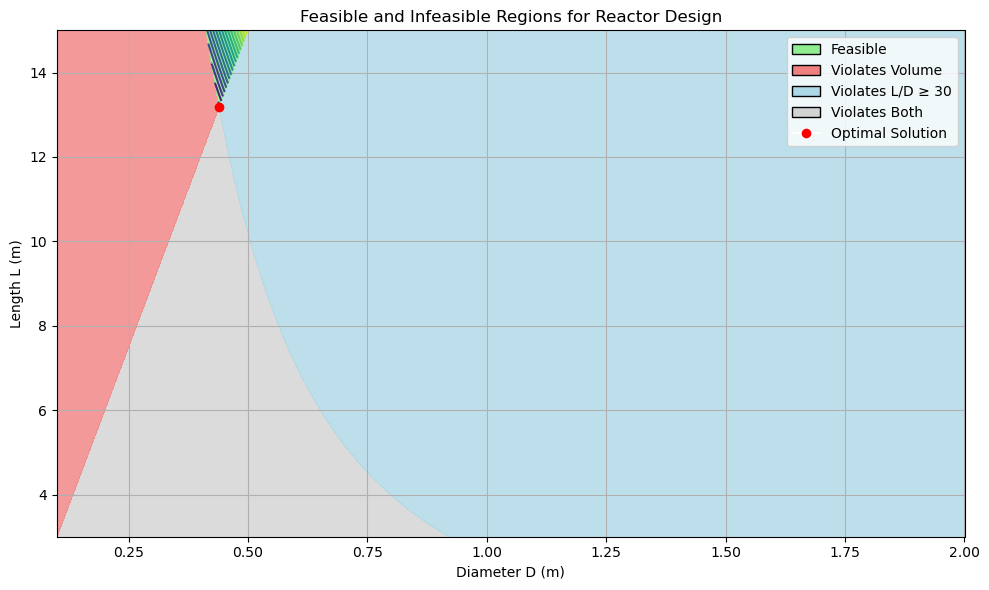

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create grid based on bounds
D_vals = np.linspace(0.1, 2.0, 3000)
L_vals = np.linspace(3.0, 15.0, 3000)
D_grid, L_grid = np.meshgrid(D_vals, L_vals)

# Recalculate surface area, volume, and L/D
A_grid = np.pi * (D_grid * L_grid + 0.5 * D_grid**2)
V_grid = (np.pi * D_grid**2 / 4) * L_grid
L_by_D_grid = L_grid / D_grid

# Classify feasibility
feasible = (V_grid >= 2.0) & (L_by_D_grid >= 30)
vol_only = (V_grid < 2.0) & (L_by_D_grid >= 30)
ld_only = (V_grid >= 2.0) & (L_by_D_grid < 30)
both_violated = (V_grid < 2.0) & (L_by_D_grid < 30)

# Start plot
plt.figure(figsize=(10, 6))

# Shaded regions
plt.contourf(D_grid, L_grid, both_violated, levels=[0.5, 1], colors=['lightgray'], alpha=0.8)
plt.contourf(D_grid, L_grid, vol_only, levels=[0.5, 1], colors=['lightcoral'], alpha=0.8)
plt.contourf(D_grid, L_grid, ld_only, levels=[0.5, 1], colors=['lightblue'], alpha=0.8)
plt.contourf(D_grid, L_grid, feasible, levels=[0.5, 1], colors=['lightgreen'], alpha=0.8)

# Surface area contours over feasible region only
A_feasible = np.ma.masked_where(~feasible, A_grid)
contour = plt.contour(D_grid, L_grid, A_feasible, levels=20, cmap='viridis')

# Optimal solution point
plt.plot(D_opt, L_opt, 'ro', label='Optimal Solution')

# Labels and legend
plt.xlabel('Diameter D (m)')
plt.ylabel('Length L (m)')
plt.title('Feasible and Infeasible Regions for Reactor Design')
plt.grid(True)

# Custom legend
legend_elements = [
    Patch(facecolor='lightgreen', edgecolor='black', label='Feasible'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Violates Volume'),
    Patch(facecolor='lightblue', edgecolor='black', label='Violates L/D ≥ 30'),
    Patch(facecolor='lightgray', edgecolor='black', label='Violates Both'),
    plt.Line2D([0], [0], marker='o', color='w', label='Optimal Solution',
               markerfacecolor='red', markersize=8)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


## 5) Derivative-free optimization (quick note)

When the function we are trying to optimize ($f$) is **noisy, discontinuous, or nonsmooth**, gradients/Hessians can be unreliable.  
**Nelder–Mead** (simplex search) in `scipy.optimize.minimize` uses only function values — robust to noise but slower and can stagnate in higher dimensions. But sometimes, it can be a viable option.


$$f(x,y) = (x-1)^2 + 10\,(y-2)^2 + 0.05\cos(3x) + 0.05\sin(2y)$$

In [15]:
# Nelder–Mead demo (derivative-free)
def f_nm(v):
    x, y = v
    return (x-1)**2 + 10*(y-2)**2 + 0.05*np.cos(3*x) + 0.05*np.sin(2*y)


res_nm = minimize(f_nm, 
                  x0=[-2.0, 4.0], 
                  method='Nelder-Mead',
                  options={'xatol':1e-8, 'fatol':1e-8, 'maxiter':2000})


print("Nelder-Mead:", res_nm.x, "| nit:", res_nm.nit, "| success:", res_nm.success)

Nelder-Mead: [1.00865317 2.0032436 ] | nit: 90 | success: True


Running scipy.optimize.minimize with default options.

In [16]:
res_defaults = minimize(f_nm, x0=[-2.0, 4.0])

print("scipy default:", res_defaults.x, "| nit:", res_defaults.nit, "| success:", res_defaults.success)

scipy default: [1.00865348 2.00324374] | nit: 7 | success: True


Look how faster gradient-based optimization can be! (e.g., 90 iterations using simplex vs 7)

Let's check if we are at an optimal solution...

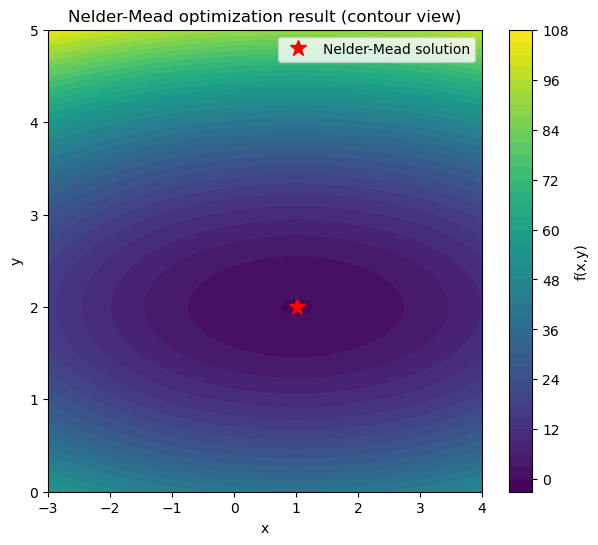

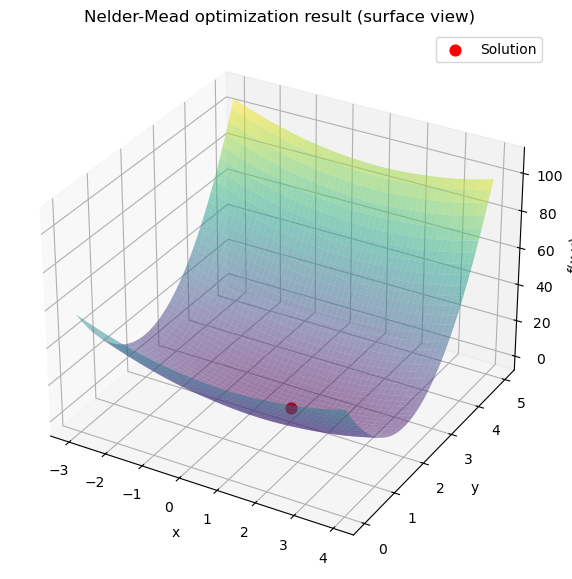

In [17]:
# Create grid for visualization
xgrid = np.linspace(-3, 4, 200)
ygrid = np.linspace(0, 5, 200)
X, Y = np.meshgrid(xgrid, ygrid)
Z = f_nm((X, Y))

# Contour plot
plt.figure(figsize=(7,6))
cp = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
plt.colorbar(cp, label="f(x,y)")
plt.plot(res_nm.x[0], res_nm.x[1], "r*", markersize=12, label="Nelder-Mead solution")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Nelder-Mead optimization result (contour view)")
plt.legend()
plt.show()

# 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", alpha=0.5)
ax.scatter(res_nm.x[0], res_nm.x[1], f_nm(res_nm.x), color="red", s=60, label="Solution")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x,y)")
ax.set_title("Nelder-Mead optimization result (surface view)")
ax.legend()
plt.show()

## Some final thoughts...

1. Optimization and root finding are related as we could see today. But further conditions must be checked/satisfied (curvature). Optimization is a huge research field, with real world applications!
2. Curve fitting is a form of optimization problem. We are minimizing the errors between a model prediction and data, by numerically manipulating a set of parameters using the optimization algorithm. This is closely-related to training in machine learning!
3. Sometimes, we may not have access to derivatives. Hence, derivative-free methods can be important.